# imports

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Lesson 1 example 1

In [51]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

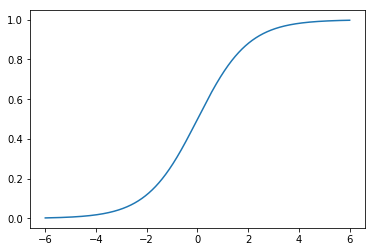

In [52]:
x = np.arange(-6, 6, 0.001)
y = logistic(x)

plt.plot(x, y)
plt.show()

   # Lesson 1 example 2

In [53]:
def train_test_split_example(df, test_fraction):
    test_df = df.sample(frac = test_fraction)
    train_df = df.drop(test_df.index)
    return (train_df, test_df)

In [54]:
def pre_process(df, threshold):
    # Pre-process the LendingClub loan data.
    # Args:
    #    df - the loan data in dataframe format
    #    threshold - interest rate threshold for classification
    # Returns:
    #    a pre-processed dataframe
    
    # classify by interest rate
    df['class'] = df['Interest.Rate'].apply(
        lambda x: 1.0 if float(x.replace('%', '')) <= threshold else 0.0)

    # select the minimum FICO score
    df['fico_score'] = df['FICO.Range'].apply(
        lambda x: float(x.split('-')[0]))

    # standardize the FICO score to a range of 0 to 1
    fico_min = df['fico_score'].min()
    fico_max = df['fico_score'].max()
    fico_range = fico_max - fico_min
    df['fico_score'] = df['fico_score'].apply(
        lambda x: (x - fico_min)/fico_range)

    return df[['fico_score', 'class']]

In [55]:
class LogisticRegressionModel(torch.nn.Module):

    def __init__(self, input_dim, output_dim):

        # call class constructor
        super(LogisticRegressionModel, self).__init__()

        # use the nn package to create a linear layer
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):

        # First we pass the input through the linear layer,
        # then we pass that through sigmoid, which implements the logistic function.
        out = torch.sigmoid(self.linear(x)) 
        return out

In [56]:
def log_reg_fit(x, y, learning_rate, epochs):
    # Train a logistic regresson model using SGD and pytorch. 
    # Args:
    #    x - feature array, a numpy array
    #    y - response array, a numpy array
    #    learning_rate - learning rate used in SGD
    #    epochs - number of epochs for the SGD loop
    # Returns:
    #    The trained model

    # number of dimensions in incoming data
    input_dimension = x.ndim
    output_dimension = y.ndim

    # if the features are a 1-d array (a list), turn into a 2d column vector
    if input_dimension == 1:
        x = x[:, np.newaxis]
        input_size = 1
    else:
        input_size = x.shape[1]

    if output_dimension == 1:
        y = y[:, np.newaxis]
        output_size = 1
    else:
        output_size = y.shape[1]

    # initialize the model
    model = LogisticRegressionModel(input_size, output_size)

    # error/loss function
    criterion = torch.nn.BCELoss()

    # SGD optimizer
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        # feature and response variables
        features = Variable(torch.from_numpy(x).float())
        labels = Variable(torch.from_numpy(y).float())

        # clear the gradients
        optimiser.zero_grad()

        # calculate predicted values
        predictions = model.forward(features)

        # calculate loss
        loss = criterion(predictions, labels)

        # calculate the derivative/gradient for each feature
        loss.backward()
        
        # based on the gradients, take a step in the right direction
        optimiser.step()

    return model

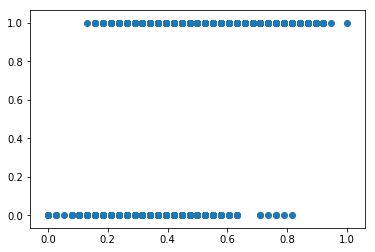

In [62]:
# import the loan data
raw_df = pd.read_csv('s3://helen-ml/week-3/loan_data.csv')

# pre-process the loan data, with 12% as the classification threshold
df = pre_process(raw_df, 12.0)

plt.scatter(df['fico_score'], df['class'])
plt.show()

In [ ]:

# split data into training and test sets
train, test = train_test_split(df, test_size=0.2)

# train model
model = log_reg_fit(train['fico_score'].values, train['class'].values, 0.1, 10000)

# make predictions on test data
raw_predictions = model(Variable(torch.from_numpy(test['fico_score'].values[:, np.newaxis]).float()))

# convert probability into discrete 1/0 predictions
predictions = []
for prediction in raw_predictions:
    if prediction.data.numpy()[0] > 0.50:
        predictions.append(1.0)
    else:
        predictions.append(0.0)

# calculate accuracy
acc = accuracy_score(test['class'].values, predictions)
print('Accuracy: ', acc)